## Import essential libraries



In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Subset
import os
import numpy as np


## Set dataset directory path and define image transformations
### - train_transform includes random crop, color jitter (data augmentation), and normalization
### - eval_transform resizes the image to 224x224 without augmentation for validation/testing
### Load the dataset using ImageFolder with the training transformations


In [2]:
data_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'  # Adjust directory as needed

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

#/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/

## Split dataset into train, validation, and test sets
### - 90% for training, 5% for validation, 5% for testing
### - Use a fixed seed for reproducibility

## Set evaluation transforms for val and test datasets


In [3]:
total_len = len(full_dataset)
train_len = int(0.90 * total_len)
val_len = int(0.05 * total_len)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42)
)

# Assign eval transform to val and test sets
val_dataset.dataset.transform = eval_transform
test_dataset.dataset.transform = eval_transform

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)



## Load ViT (Vision Transformer) base model pre-trained on ImageNet-1K
### - Freeze all layers initially to use as a feature extractor

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(full_dataset.classes)

model = models.vit_b_16(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
for param in model.heads.head.parameters():
    param.requires_grad = True

model = model.to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 199MB/s]  


## Training Loop
### - Loop through each epoch

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.heads.head.parameters(), lr=1e-3)
num_epochs = 15  # Increase as needed

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")


Epoch 1: Train Loss=0.2656, Train Acc=0.9449
Epoch 2: Train Loss=0.0616, Train Acc=0.9850
Epoch 3: Train Loss=0.0395, Train Acc=0.9902
Epoch 4: Train Loss=0.0282, Train Acc=0.9930
Epoch 5: Train Loss=0.0222, Train Acc=0.9944
Epoch 6: Train Loss=0.0177, Train Acc=0.9957
Epoch 7: Train Loss=0.0150, Train Acc=0.9962
Epoch 8: Train Loss=0.0123, Train Acc=0.9971
Epoch 9: Train Loss=0.0102, Train Acc=0.9978
Epoch 10: Train Loss=0.0097, Train Acc=0.9977
Epoch 11: Train Loss=0.0082, Train Acc=0.9980
Epoch 12: Train Loss=0.0070, Train Acc=0.9985
Epoch 13: Train Loss=0.0067, Train Acc=0.9984
Epoch 14: Train Loss=0.0057, Train Acc=0.9988
Epoch 15: Train Loss=0.0052, Train Acc=0.9988


## Evaluate the model on validation and test datasets
### - Calls `evaluate` function on both loaders
### - Prints formatted accuracy values

In [6]:
def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
    return correct / total

val_acc = evaluate(val_loader)
test_acc = evaluate(test_loader)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Validation Accuracy: 0.9932
Test Accuracy: 0.9929


## Save Trained Model
### - Saves the model's learned weights (state_dict)

In [7]:
torch.save(model.state_dict(), '/kaggle/working/vit_plantdisease.pt')
print("PyTorch model weights saved to /kaggle/working/vit_plantdisease.pt")


PyTorch model weights saved to /kaggle/working/vit_plantdisease.pt


## Visualize random samples:
### - Display actual vs predicted class
### - Denormalize image for correct color display
### - Useful to visually inspect model accuracy

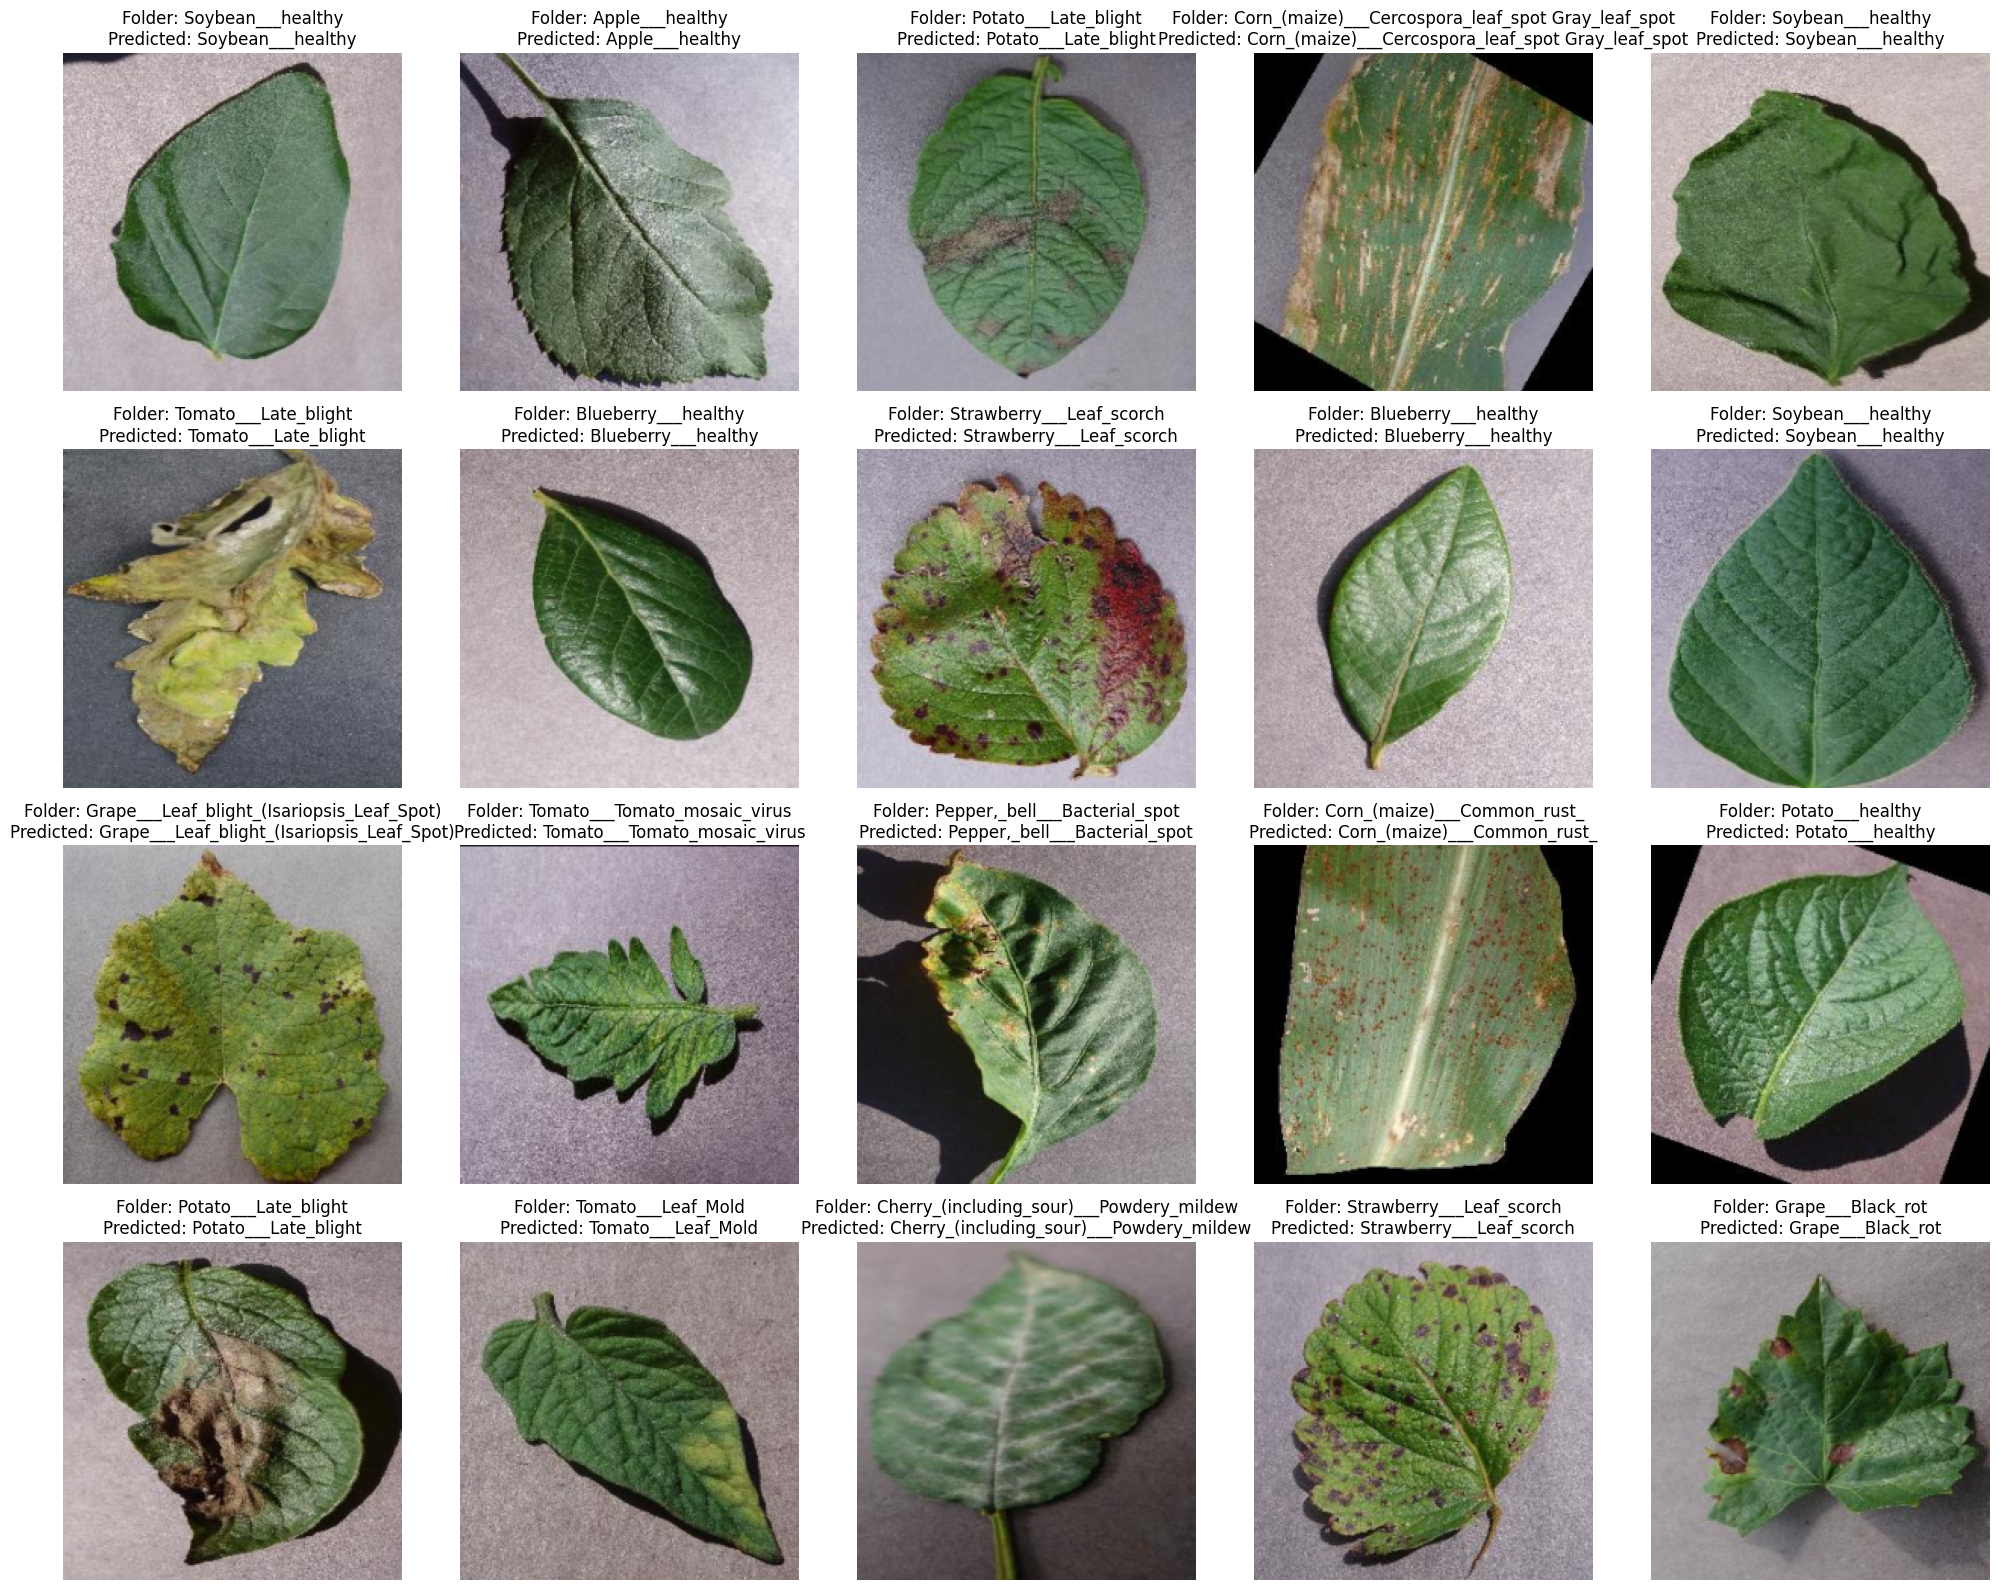

In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt
import numpy as np

# Unnormalize function (for display)
def unnormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Dataset and model setup (adjust data_dir/model as needed)
data_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
full_dataset = datasets.ImageFolder(root=data_dir, transform=eval_transform)

# Select 20 random images
num_samples = 20
indices = random.sample(range(len(full_dataset)), num_samples)
subset = Subset(full_dataset, indices)
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

# Predict and plot
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for i, (img, label) in enumerate(subset_loader):
    img_in = img.to(device)
    with torch.no_grad():
        out = model(img_in)
        _, pred = out.max(1)
    actual = full_dataset.classes[label.item()]
    predicted = full_dataset.classes[pred.item()]
    img_disp = unnormalize(img.cpu().squeeze())
    axes[i].imshow(img_disp)
    axes[i].set_title(f"Folder: {actual}\nPredicted: {predicted}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
